# Machine Learning LAB 6: CLASSIFICATION - Characters Classification with Neural Networks

Course 2024/25: *F. Chiariotti*

The notebook contains some simple tasks about **CLASSIFICATION**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Characters Classification with Neural Networks

In this notebook we are going to use the **Neural Networks** for image classification. We are going to use a dataset of traditional japanese handwritten kana: [*Kuzushiji-MNIST*](https://github.com/rois-codh/kmnist) (or *K-MNIST* for short).

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

---

---

## Import all the necessary Python libraries

In [14]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_mnist` -> function to load the K-MNIST dataset,
2. `plot_input` -> function to plot the input image,
3. `param_count`-> function to compute the number of learnable parameters of a MLP (Multi Layer Perceptron) given the size of its hidden layers,
4. `plot_accuracies` -> function to plot the accuracies of the MLP,
5. `plot_losses` -> function to plot the losses of the MLP,
6. `plot_conf_matrix` -> function to plot the confusion matrix of the MLP.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [15]:
# This function is responsible for loading the K-MNIST dataset from compressed .gz files and returning the images and labels as NumPy arrays
def load_mnist(path: str, kind: str = 'train') -> tp.Tuple[np.ndarray, np.ndarray]:
    # Define the path to the data
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind) # points to the labels file (for training labels)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind) # points to the images file (for training images)
    
    # Load the data into numpy arrays (from the gzip files)
    with gzip.open(labels_path, 'rb') as lbpath: #use gzip to open the file
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8) # read the label data, skipping the first 8 bytes (header information)
    with gzip.open(images_path, 'rb') as imgpath: # same here but will skip 16 bytes of header
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784) #each image is flattened into a 1D array of 784 pixels (since the original images are 28x28)

    # Return two numpy arrays: 
    # images --> N x 784 array (N is the number of images)
    # labels --> N - element array containing the class labels (0-9)
    return images, labels

In [16]:
#function for plotting an image and printing the corresponding label
def plot_input(data: np.ndarray, labels: np.array, index) -> None:
    if type(index) == int: # this is simply needed for the function to work consistently whether we pass a single index or multiple ones
        index = [index]
    
    _, ax = plt.subplots(1, len(index)) # creates a figure(anonymus) with multiple subplots (one for each image in index)

    if type(ax) != np.ndarray: # again, if only one image is being displayed, ax is not an array, so we convert it into a list for consistency
        ax = [ax]

    # loop through selected indices and plot images
    for i, ax in enumerate(ax):
        ax.imshow(
            data[index[i]].reshape(28, 28), # reshape the flattened 784-pixel array into a 28×28 grayscale image
            cmap=plt.cm.gray_r, # use a grayscale colormap
            interpolation="nearest" # ensures the pizels are displayed without smoothing
        ) 
        ax.set_title("Label: %i" % labels[index[i]], fontsize = 10, color = "grey") # sets the title of each subplot with the corresponding label.
        # hide axis ticks for better visualization.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    # displays the plot and then close it
    plt.show(); 
    plt.close()

In [17]:
# compute the number of learnable parameters in a Multi-Layer Perceptron based on its architecture
def param_count(hl_size: int, x: np.ndarray, y: np.ndarray) -> int:
    tot = 0 # this variable will store the total number of parameters
    input_size, output_size = x.shape[1], len(y) # notice that y must be the set of UNIQUE labels
    tot += (input_size+1)*hl_size[0] # compute the number of parameters for the first hidden layer
    for i in range(1,len(hl_size)): # do the same for next layers
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size # add the parameters for the output layer
    return tot

In [18]:
# function to visualize the accuracy trends of different neural network architecture based on the number of learnable parameters
# NOTICE: accuracy measures how many predictions are correct relative to the total number of predictions (correct/total, eventually multiplied by 100)
# If we're using 0-1 loss, then training risk is 1 - accuracy BUT generally 0-1 loss is not used in NN training because it's not differentiable 
# (so we can't use SGD, Adam ...) we generally use cross-entropy or hinge loss
def plot_accuracies(accuracies: tp.List[float], hl_labels: tp.List[str], titles: tp.List[str] = None) -> None:
    # create subplots one FOR EACH ACCURACY LIST in accuracies
    # NOTICE: the figure width is scaled dinamically to fit all subplots
    _, ax = plt.subplots(1, len(accuracies), figsize=(6 * len(accuracies), 5))

    if type(ax) != np.ndarray:
        ax = [ax] # ensures ax is a list

    #loop through each accuracy plot
    for i, ax in enumerate(ax):
        ax.plot(accuracies[i])
        ax.set_xlabel("Number of learnable params")
        ax.set_title("Accuracy")
        ax.set_xticks(np.arange(0,len(hl_labels[i])))
        ax.set_xticklabels(hl_labels[i])
        if titles is not None:
            ax.set_title(titles[i])
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

In [19]:
# function to visualize the loss values over iterations for different learning rates
def plot_loss(losses: tp.Dict[float, np.ndarray]) -> None:
    legend = True

    # Plot all the losses
    for key, value in losses.items():
        # key represents learning rate (or none if not specified)
        # value is an array of loss values over iterations
        if key == None:
            plt.plot(value) # plot the loss without a label
            legend = False
        else:
            plt.plot(value, label=f"lr: {key}") # label the curve with the learning rate

    # Plot the legend, title and labels
    plt.title("Losses")
    if legend:
        plt.legend(loc = 1)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()
    plt.close()

In [20]:
# function to visualize the confusion matrix as a heatmap using the seaborn library. This helps you understand the performance of a classification model by showing the true vs predicted labels.
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    # Plot the confusion matrix 
    sns.heatmap(conf_matrix, annot=True, fmt="d") # annot = True adds numeric vaues in each cell of the matrix; fmt="d" ensures values are displayed as integers
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

### **ABOUT CONFUSION MATRIX**

The confusion matrix is a square matrix with dimensions equal to the number of classes (e.g., 10 classes for K-MNIST). Each cell in the matrix represents a count of how often a certain combination of true and predicted labels occurs.

#### **Matrix Structure**

The matrix has the following structure:
- Rows represent **true labels** (what the model should predict).
- Columns represent **predicted labels** (what the model actually predicted).

For a binary classification problem (2 classes), the confusion matrix looks like this:

|               | Predicted: 0 | Predicted: 1 |
|---------------|--------------|--------------|
| **True: 0**   | **TP**       | **FN**       |
| **True: 1**   | **FP**       | **TN**       |

Where:
- **TP (True Positive)**: The number of times the model correctly predicted class 0 when the true label was 0.
- **TN (True Negative)**: The number of times the model correctly predicted class 1 when the true label was 1.
- **FP (False Positive)**: The number of times the model incorrectly predicted class 1 when the true label was 0.
- **FN (False Negative)**: The number of times the model incorrectly predicted class 0 when the true label was 1.

### **How to Read the Confusion Matrix**
- **Diagonal Elements (TP)**: These are the cases where the model predicted the class correctly. For example, the value at position (0,0) represents the number of **correct predictions for class 0**.
- **Off-Diagonal Elements**: These represent **misclassifications**. For example:
  - (0,1) represents how many times the model **predicted class 1 when it should have predicted class 0**.
  - (1,0) represents how many times the model **predicted class 0 when it should have predicted class 1**.

### **Metrics Derived from the Confusion Matrix**
From the confusion matrix, you can calculate several performance metrics, such as:

1. **Accuracy**:  
   The percentage of correct predictions.  
   $$
   \text{Accuracy} = \frac{\text{Sum of Diagonal}}{\text{Total Number of Samples}}
   $$

2. **Precision** (for each class):  
   The proportion of true positives (correctly classified for that class) out of all predicted positives.  
   $$
   \text{Precision}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FP}_i}
   $$

3. **Recall** (for each class):  
   The proportion of true positives out of all actual positives.  
   $$
   \text{Recall}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i}
   $$

4. **F1 Score**:  
   The harmonic mean of precision and recall, often used when dealing with imbalanced classes.


N.B: in general here, positive (for class i) = class i, negative if it is another class. 
For example, false positives for the i-th class are points that are predicted as i but their true label is not i. 

---

## A) Classification with Neural Networks (using Scikit-Learn)

In the first part of this notebook we are going to implement a simple *MLP* using the *Scikit-Learn* library.

Now load the dataset using the `load_mnist` function and and rescale the data in the range [0,1].
Rescaling is important for neural networks to work efficiently. Models like MLPs (Multi-Layer Perceptrons) benefit from having input features in a similar range (typically [0,1] or [-1,1]) to ensure that the gradient descent optimization process works better.

In [21]:
# Load the data
x, y = load_mnist("data")

# Print the number of samples in the dataset
print("Number of samples in the MNIST dataset:", x.shape[0])

# Print the minimum and maximum values of the input
print("Minimum and maximum values of the input:", np.min(x), np.max(x))

# Rescale the data in [0,1]
x = x / np.max(x)

# Print the minimum and maximum values of the input after rescaling
print("Minimum and maximum values of the input after rescaling:", np.min(x), np.max(x))

Number of samples in the MNIST dataset: 60000
Minimum and maximum values of the input: 0 255
Minimum and maximum values of the input after rescaling: 0.0 1.0


Now split into training and test. We start with a small training set of $600$ samples to reduce computation time while $4000$ samples will be used for testing. Make sure that each label is present at least $10$ times in the training set (you see the values in frequencies list).

In [73]:
# Random permute the data (both train and test set) and split into training and
# test taking the first 600 data samples as training and the rests as test

# Create a list of indices
idx = np.arange(x.shape[0])
# Randomly shuffle the indices
np.random.shuffle(idx)
# Shuffle the dataset
x = x[idx]
y = y[idx]
n=x.shape[0]

# We split the dataset in train and test
m_training=600

# m_test is the number of samples in the test set (total-training)
m_test =  x.shape[0] - m_training
X_training =  x[:m_training]
Y_training =  y[:m_training]
X_test =   x[m_training:]
Y_test =  y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\n")

# Print the number of unique labels (with the correspondent 
# frequency) in the training set and in the test set

labels_train, freqs_train = np.unique(Y_training, return_counts=True) # NOTICE that you can use np.unique itself to do the counts!!!!
print("Labels in training dataset: ", labels_train)
print("Frequencies in training dataset: ", freqs_train)
print("\n")
labels_test, freqs_test = np.unique(Y_test, return_counts=True)
print("Labels in test dataset: ", labels_test)
print("Frequencies in test dataset: ", freqs_test)


Number of samples in the train set: 600
Number of samples in the test set: 59400


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [68 36 62 59 71 65 73 53 60 53]


Labels in test dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test dataset:  [5932 5964 5938 5941 5929 5935 5927 5947 5940 5947]
(600, 784)


Plot three samples from the dataset, together with their label (use the function))

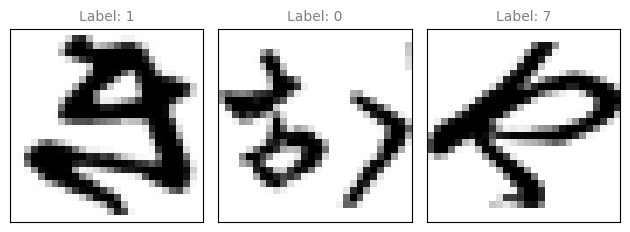

In [23]:
ind=np.random.randint(0, x.shape[0], 3)
plot_input(x,y,ind) 

Now use a feed-forward Neural Network for prediction. 

Use the **multi-layer perceptron classifier**, with the following parameters: 

- max_iter = $200$ (maximum number of iterations for the training process --> epochs the optimization algorithm will run for during the training process, here SGD)
  
- alpha = $1 \cdot 10^{-4}$ (this is the regularization term to prevent overfitting: it is the L2 regularization, also called ridge regularization)

- solver = 'sgd' (ptimizer for the neural network, Stochastic Gradient Descent (SGD))

- tol = $1 \cdot 10^{-4}$ (tolerance for stopping criteria: stopping early id the improvement is smaller than this value)

- learning_rate_init = $0.1$ (initial learning rate used by SGD: default is constant but can be made adaptive using the learning_rate = 'adaptive' key). 

- random_state = ID (this last parameter ensures the run is the same even if you run it more than once). 

Then, using the **default activation function**, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. 
It is not necessary to create huge neural networks, you can limit to $3$ layers and, for each layer, its maximum size can be of $50$. 

Evaluate the architectures you chose using **GridSearchCV** with cv = $5$.
It tries every combination of the hyperparameters in parameters grid, training using cross validation and computing cross validation score and tells you which one is the best-performing configuration.

You can reduce the number of iterations if the running time is too long on your computer.

NOTICE: **GRIDSEARCHCV attributes**
> best_estimator: is the model that performed best (contains the FULL MODEL!)

> best_score: is the performance score of the best model on validation set during cross-validation.

> best_params are the hyperparameters of the best model

> cv_results: is a detailed record of all parameter combinations and their associated performance scores.

In [38]:
# These are sample values but feel free to change them as you like,
# try to experiment with different sizes!!
#parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10)]}
parameters = {'hidden_layer_sizes': [(1,),(3,),(5,),(10,), (20,), (40,), (20,20,),(30,30,20)]}

# Create a MLP classifier using scikit-learn
MLP=MLPClassifier(activation = 'relu', max_iter = 200, alpha = 1e-4, solver = 'sgd',tol = 1e-4,
                  learning_rate_init = 0.1)

# Perform a grid search varying over the given parameters
# GridSearchCV tunes the hidden_layer_sizes parameter over the given architectures (parameters)
# cv stands for cross validation with (in this case) 5 folds to estimate the generalization performance of each model
models=GridSearchCV(MLP,parameters,cv=5) # this only initializes a GridSearch object with the given arguments, but does not yet perform the search, it is just setting up the grid search.
models.fit(X_training,Y_training) # this command starts the process of searching for the best model through cross-validation
                                # After it finishes, you can access models.best_estimator_, models.best_score_, and models.best_params_ to see the best-performing model and its corresponding hyperparameters.

# Print the best estimator parameters
print("the best model is:\n")
print(models.best_estimator_)
print("\n")
print("with score {:.2f}".format(models.best_score_))
print("and best parameters {}".format(models.best_params_))

the best model is:

MLPClassifier(hidden_layer_sizes=(40,), learning_rate_init=0.1, solver='sgd')


with score 0.73
and best parameters {'hidden_layer_sizes': (40,)}


### Evaluate the best model

Plot the train and test accuracies as a function of the number of neurons in your neural network. Print also the computation time for the various configuration you try.

While performing the *MLP* train with different hidden layer sizes evaluate also the time spend for the training by each different configuration. We can use the `time` library to measure the time spent for the training.

Keep in mind that to use the `time()` function we need to import the `time` library (already done at the beginning of this notebook).

**NOTICE:**
Both mlp.fi() and gridsearch.fit() are used for training models, but they serve different purposes.

| Function | Purpose | What it does |
|----------|---------|--------------|
| **`mlp.fit(X, Y)`** | Trains a **single** MLP model | Uses the provided hyperparameters and fits the model to the training data. |
| **`GridSearchCV.fit(X, Y)`** | Finds the **best hyperparameters** | Runs multiple `mlp.fit()` calls with different hyperparameters, evaluating each one using cross-validation. |

Earlier we passed `MLPClassifier` to `GridSearchCV` because `GridSearchCV` is responsible for training several versions of the model with different hyperparameters.
It iterates over the possible hyperparameter values (e.g., different hidden layer sizes) and **calls `fit()` internally** for each combination.

Training MLP of size (1,) ...
Time needed for training: 0.17 seconds
Training MLP of size (3,) ...
Time needed for training: 0.31 seconds
Training MLP of size (5,) ...
Time needed for training: 0.64 seconds
Training MLP of size (10,) ...
Time needed for training: 0.86 seconds
Training MLP of size (20,) ...
Time needed for training: 1.15 seconds
Training MLP of size (40,) ...
Time needed for training: 1.53 seconds
Training MLP of size (20, 20) ...
Time needed for training: 1.85 seconds
Training MLP of size (30, 30, 20) ...
Time needed for training: 2.09 seconds


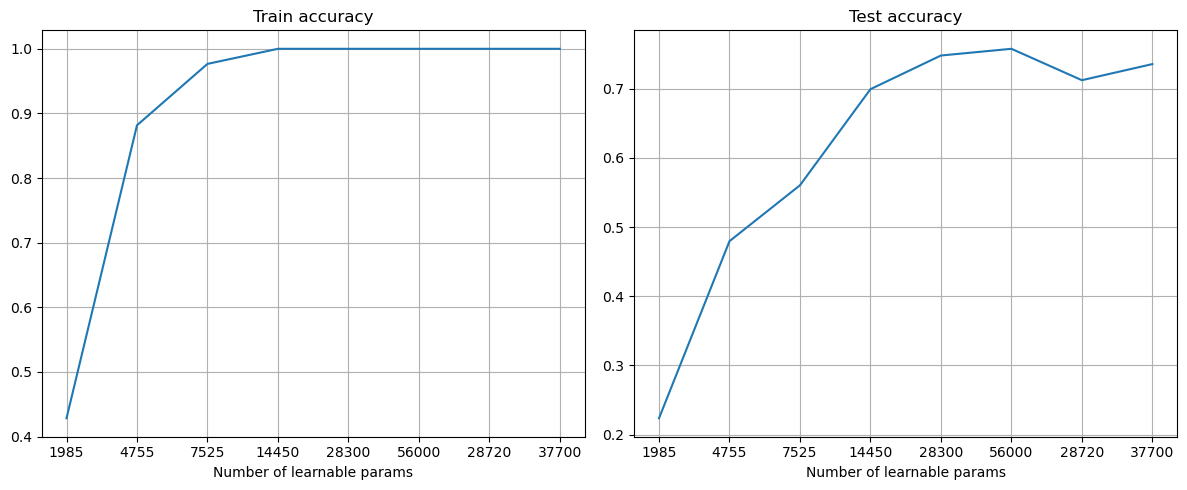

In [39]:
# Define the list of hidden layer sizes to try out (feel free to change)
hidden_layer_sizes = [(1,),(3,),(5,),(10,), (20,), (40,), (20,20,),(30,30,20)]
# Define the corresponding number of neurons in the neural network
hidden_layer_labels = [param_count(size, X_training, Y_training) for size in hidden_layer_sizes]

# Train the MLPs with the different hidden layer sizes and get the accuracies
start_time = time()  # Start time
train_accuracies, test_accuracies = [], []  # Lists for saving accuracies (train and test)

for size in hidden_layer_sizes:
    print(f"Training MLP of size {size} ...")
    
    # TODO: Define and train the MLP object
    mlp = MLPClassifier(hidden_layer_sizes=size, activation='relu', max_iter=200, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=0.1)    
    # Train the MLP object
    mlp.fit(X_training, Y_training)
    # Find the time needed for training
    elapsed_time = time() - start_time
    # Save the accuracies in the correct lists
    train_accuracies.append(mlp.score(X_training, Y_training))
    test_accuracies.append(mlp.score(X_test, Y_test))
    
    # Print the time needed for training
    print(f"Time needed for training: {elapsed_time:.2f} seconds")

 # Plot the train and test accuracies
plot_accuracies([train_accuracies, test_accuracies], [hidden_layer_labels, hidden_layer_labels], ["Train accuracy", "Test accuracy"])


### Learning rate tuning

Now try also to use different learning rates, while keeping the best *NN* architecture and batch size you have found above.

Plot the learning curves (*i.e.*, the variation of the loss over the steps, you can get it from the `loss_curve_` object of sklearn) for the different values of the learning rate. Try to run each training for $600$ iterations. Plot all the curves in the same plot.

**NOTICE:**
models (that was defined as models=GridSearchCV(MLP,parameters,cv=5)): 

> Depends only on the first set of parameters (those passed to GridSearch), not on the hidden_layer_sizes of the manual loop training

> Does NOT get update automatically if you change MLP after defining models.

Therefore, if you want consistency between the two cells (the GridSearch and the manual trainig), you have to make sure that: 

> Parameters (hidden_layer_sizes) you try are the same

> The arguments of MLP and those used in mlp are the same (for example tol, max_iterations and so on...)

Best learning rate value:  0.2  with score:  0.7643602693602694


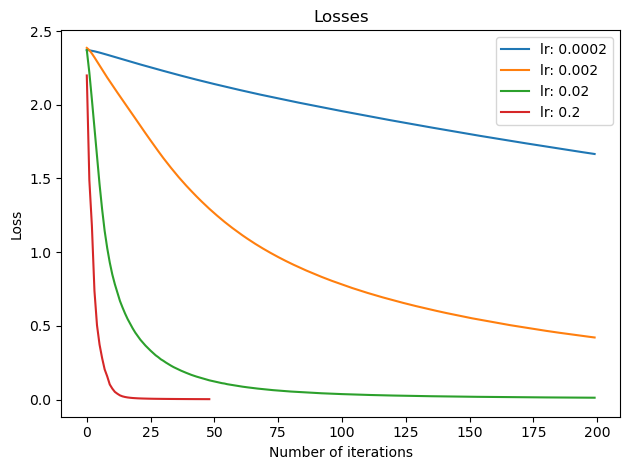

In [44]:
# Define the list of learning rates to try out (feel free to change)
lr_list = [0.0002, 0.002, 0.02, 0.2]

# Train the MLPs with the different lerning rates
scores = {}  # dictionary for saving the scores
losses = {}  # dictionary for saving losses

# Get the best hidden layer sizes and batch size from the previous 
hidden_layers=models.best_params_

# TODO: Train the MLPs with the different learning rates and get the scores
for lr in lr_list: 
    # NOTICE: to mlp you need to pass hidden_layers['hidden_layer_sizes'] because hidden_layers is a dictionary like {'hidden_layer_sizes': (40, 20)}
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers['hidden_layer_sizes'], activation='relu', max_iter=200, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=lr)    
    mlp.fit(X_training, Y_training)
    # NOTICE: update is a dictionary method that allows you to add or modify multiple key-value pairs at once
    scores.update({f'{lr}': mlp.score(X_test, Y_test)}) # here we're adding (or updating) the values of each lr
    losses.update({f'{lr}': mlp.loss_curve_})
    
# Print the best learning rate value and the corresponding score
# NOTICE: dict.get() is another dictionary method that retrieves the value of a given key
# If the key doesn't exist returns None instead of a KeyError. 
# NOTICE: the following line finds the key (learning rate) that corresponds to the highest accuracy
key_best = max(scores, key = scores.get)
print("Best learning rate value: ", key_best, " with score: ", scores[key_best])

# Plot the losses (using the helper function defined at the beginning of the notebook)
plot_loss(losses)

**COMMENTS:**
Here you can see something that we've discussed in class: 
- if you increase the learning rate the loss on the training set will decrease rapidly, while if we have a small learning rate it will be much slower.
  
- of course there are also some stability arguments for choosing the learning rate that here you can't really see, but in general setting a too high lr can lead to numerical problems such as divergence or we could have oscillascions around the minimum.

### Test the best model

Now get training and test error for a NN with best parameters (architecture and learning rate) from above. Plot the learning curve also for this case.

Training error:  0.0
Test error 0.23289562289562293


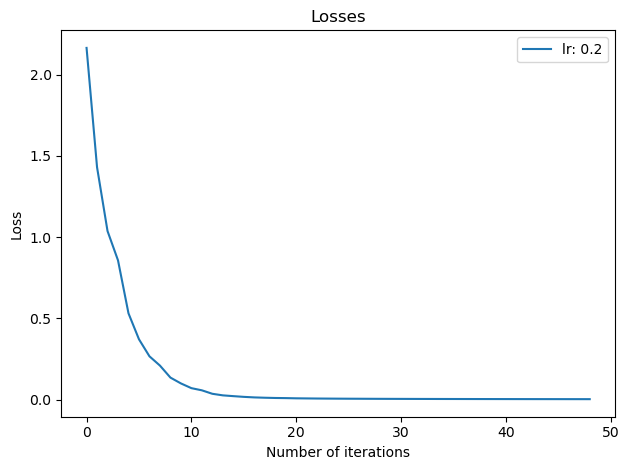

In [47]:
# Define the parameters for the best NN model from CV
best_hidden_layers = hidden_layers['hidden_layer_sizes']
best_learning_rate = 0.2

# TODO: Train the best NN model with the best parameters and compute the training and test error
best_MLP = MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation='relu', max_iter=200, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=best_learning_rate)
best_MLP.fit(X_training, Y_training)
train_error = 1 - best_MLP.score(X_training, Y_training)
test_error = 1 - best_MLP.score(X_test, Y_test)
print("Training error: ", train_error)
print("Test error", test_error)

# TODO: Plot the loss curve for the best NN model
plot_loss({best_learning_rate: best_MLP.loss_curve_})


**COMMENT:**
It's overfitting quite a bit because we used very few samples for training. This was necessary also because we did a lot of tests and it takes quite a long time to train. With 600 samples it takes a few seconds, if you increase the size of the dataset it's gonna take longer and longer of course. 

---

## B) Classification with Neural Networks (with custom implementation)

In the second part of this notebook we are going to implement a simple *MLP* from scratch. We are going to use the same dataset as before.

### ACTIVATION CLASS
    
Define the Activation class that implements the activation functions and the correspondent derivative. In particular, implement the following activation functions: **ReLu**, **Sigmoid**.

In [64]:
class Activation:
    """
    Activation function class
    """

    def __init__(self, name: str) -> None:
        """
        Constructor for the Activation class.
        Given a string name, it sets the activation function (and derivative) to be used.
        Args:
            name (str): the name of the activation function to be used.
        """

        self.name = name

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function.
        \nReturns:
            np.ndarray: the output of the activation function and the input x (used for backpropagation).
        """

        if self.name == 'relu':
            # TODO: Implement the ReLU activation function (replace pass with your code)
            #return max(0,x), x --> this is no good because ambiguous using arrays (raises error)
            return np.maximum(0,x), x # compares two arrays and returns a new array containing the element wise maxima
            
        elif self.name == 'sigmoid':
            # TODO: Implement the Sigmoid activation function (replace pass with your code)
            return 1/(1+np.exp(-x)), x
            
        else:
            raise ValueError('Activation function not supported')

    def derivative(self, x: np.ndarray) -> np.ndarray:
        """
        Given an input x, it computes the corresponding derivative of the activation function.
        \nArgs:
            x (np.ndarray): the input to the activation function.
        \nReturns:
            np.ndarray: the derivative of the activation function.
        """

        if self.name == 'relu':
            # TODO: Implement the derivative of the ReLU activation function (replace pass with your code)
           # if x <= 0: 
           #     return 0, x
           # if x > 0: 
           #     return 1, x
           # NOTICE: the above code would break if x is a vector (which usually is in NNs). So we need to implement this differently!
           # We can use np.where(condition, value_if_true, value_if_false) which handles scalars and arrays automatically and is more efficient and concise. 
           return np.where(x > 0, 1, 0)
            
        elif self.name == 'sigmoid':
            # TODO: Implement the derivative of the Sigmoid activation function (replace pass with your code)
            num = np.exp(-x)
            den = (1 + np.exp(-x))**2
            return num/den
        else:
            raise ValueError('Activation function not supported')

### MLP CLASS

The following block contains the structure of the *MLP* class. You have to complete the `forward` function. The `forward` function should compute the forward pass of the network.

Note that to be able to perform backpropagation algorithm we have to keep track of all the computation we do in the forward pass. In particular, this is done in the `cache` variable that is stored at each layer. Note that in order to work properly with the already provided `backprop()` method, the cache has to be stored in a specific way. 

In particular we have chosen that the cache is a tuple containing `(a_prev, W, b)` where:
- `a_prev` is the output of the previous layer (np.ndarray)
- `W` is the current weight matrix (np.ndarray)
- `b` is the current bias vector (np.ndarray)

**NOTICE:**

> Rescaling w by 0.01 as follows is based on empirical results. It avoids exploding gradients and it still is large enough to allow the network to learn efficiently at start. Keep in mind that the initialization is nevertheless problem specific (depends for example on activation and so on...)

> The size of the weights matrix is not exactly the one saw in class, but it is adapted to the following steps of this code. Indeed, the multiplication here to generate the output of the current layer is: Z_t = W * a_prev + b. 


In [82]:
class DiyMlp:
    """
    A Multi-layer Perceptron implementation. (Diy stands for "Do it yourself")
    Keep in mind that all the input are considered with the batch_size as the last dimension.
    """

    def __init__(self, layers: list, learning_rate: float):
        """
        Constructor for the DiyMlp class.
        Given a list of layers and a learning rate, it initializes the parameters of the MLP.
        Each layer a part from the last one use as activation function the ReLU, while the last one uses the sigmoid.
        \nArgs:
            layers (list): a list of layers, each element of the list contains the number of neurons of the layer,
            learning_rate (float): the learning rate used during training
        """

        self.n_layers = len(layers)  # number of layers
        params = {}  # dictionary containing the parameters W and b of each layer

        # For each layer, we define the weight matrix W, the bias vector b and the activation function
        for l in range(1, self.n_layers):
            params[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * 0.01  # initialize the weight matrix of the layer to a normal distribution rescaled by 0.01
            params[f"b{l}"] = np.zeros((layers[l], 1))  # initialize the bias vector of the layer to zeros
            params[f"activation{l}"] = Activation("relu" if l < self.n_layers - 1 else "sigmoid")  # define the activation function of the layer

        self.params = params  # save the parameters of the network
        self.lr = learning_rate  # save the learning rate

    """
    The following is a helper method
    @statisticmethod is BUILT_IN Python feature that indicates that the method doesn't depend on an instance of the class to be called. 
    It can be called on the class itself, and it does not modify or access any instance variables of the class.
    --> A regular method in a class takes at least one argument (usually called self), which refers to the instance of the class. 
        This means that the method can access instance-specific data and properties (attributes).
    --> A static method, on the other hand, does not take self or cls as its first argument. 
        It behaves like a regular function but is bound to the class namespace. 
        It does not require an instance to be called and cannot access or modify instance-specific data (attributes) or class data (attributes bound to the class).
    Basically the decorator used here t is simply a way of telling Python that this method is not tied to an instance of the class but rather works independently with the data it receives as input.
    """
    
    @staticmethod
    def one_hot(x: np.ndarray, n_classes: int) -> np.ndarray:
        """
        It converts the input x into a one-hot encoding.
        \nArgs:
            x (np.ndarray): the input vector containing the labels of the samples.
            n_classes (int): the number of classes.
        \nReturns:
            np.ndarray: the one-hot encoding of x.
        Basically each element of the vector x of labels is transformed into a binary vector that represents categorical data, hence
        each element of the vector corresponds to a specific class expressed in binary. 
        For example if your problem has 4 classes: class 0 --> 1,0,0,0 ; class 1 --> 0, 1, 0, 0 
        and so on...
        """
        return np.eye(n_classes)[x.reshape(-1)]

    def forward(self, x: np.ndarray) -> tp.Tuple[np.ndarray, list]:
        """
        Implement the forward propagation of the network.
        For each layer a part the last one, it computes the linear transformation and applies the activation function.
        Given an input x, it computes the forward pass of the network.
        \nArgs:
            x (np.ndarray): the input to the network.
        \nReturns:
            np.ndarray: the output of the network.
            list: a list containing the linear and activation caches

        NOTICE: cp is a deep copy
        shallow copy --> reates a new object, but it does not copy the nested objects. 
                         Instead, it references them. This means that if you modify a nested object inside the copied object, 
                         it will also affect the original object, because both the original and the copy refer to the same nested object.
        deep copy --> creates a completely new object and recursively copies all objects found inside it, including nested objects. 
                      This means that modifying the deep copy will not affect the original object at all, because the nested objects are fully copied and independent.
        """

        caches = []  # list for storing the linear and activation caches (a_prev, W, b) for later use in backpropagation
        out = None  # output of the layer, initialized as None because it hasn't been computed yet

        # For each layer of the model except for the last one (the first layer - 0 - is the input layer)
        for l in range(1, self.n_layers):
            # NOTICE: cp is an alias for deepcopy from the copy module (imported at the beginnning of the notebook)
            # prev is storing the input of the layer, i.e., the output of the previous layer
            # if we where to be on the first layer the output of previous layer is simply a copy of the input data
            # else (for subsequent layers) is set to the value of out (output of previous layer)
            prev = cp(x) if l == 1 else out  
            
            # Linear Hypothesis
            # TODO: Compute the linear hypothesis z = W*a_prev + b (replace None with your code)
            z = np.dot(self.params[f"W{l}"], prev) + self.params[f"b{l}"]
            
            # Storing the linear cache for backpropagation = (a_prev, W, b)
            # TODO: Store the linear cache (replace None with your code)
            linear_cache = (prev, self.params[f"W{l}"], self.params[f"b{l}"])
            
            # Applying the activation function on linear hypothesis
            # TODO: Compute the activation function on z (replace None with your code)
            out, activation_cache = self.params[f"activation{l}"](z)
            
            # storing both the linear and activation cache
            caches.append((linear_cache, activation_cache))
        
        return out, caches
    
    @staticmethod
    def cost_function(out: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Given the output of the network out and the ground truth labels y, it computes the cost function (loss).
        This implementation uses the cross-entropy loss.
        \nArgs:
            out (np.ndarray): the output of the network.
            y (np.ndarray): the ground truth labels.
        \nReturns:
            np.ndarray: the cost value.

        NOTICE: In general the cross entropy loss is a measure of dissimilarity between p and q (also known as logarithmic loss)
        defined as H(p,q) = - sum_i(p_i*log(q_i)) where pi is the true probability (true label) and qi is the predicted value of the current model. 
        It works well especially for softmax activation in multi-class problems and sigmoid for binary classification. 
        It penalizes incorrect confident predictions more heavily, and it is derived from information theory, thus it measures how much information
        is lost when using predicted probabilities instead of true labels. 
        """
        
        return (-1/y.shape[1]) * (np.dot(np.log(out), y.T) + np.dot(np.log(1-out), 1-y.T))

    @staticmethod
    def one_layer_backward(d_pred: np.ndarray, cache: tp.List[tp.Tuple[np.ndarray]], derivative_activation: Activation.derivative) -> tuple:
        """
        Given the derivative of the loss with respect to the output of the layer d_pred and the linear and activation cache,
        it computes the derivative of the loss with respect to the input of the layer d_pred_prev, the derivative of the loss
        with respect to the weights d_w and the derivative of the loss with respect to the bias d_b.
        \nArgs:
            d_pred (np.ndarray): the derivative of the loss with respect to the output of the layer.
            cache (list): a list containing the linear and activation cache.
            derivative_activation (Activation.derivative): the derivative of the activation function.   
        \nReturns:
            tuple: a tuple containing the derivative of the loss with respect to the input of the layer dA_prev,
            the derivative of the loss with respect to the weights dW and the derivative of the loss with respect to the bias db.
        """

        linear_cache, activation_cache = cache  # retrieve the linear and activation cache
        
        z = activation_cache   # this is the inputs combination that is taken as argument from the activation function (what we call a_t in the lectures)
        d_z = d_pred * derivative_activation(z) # compute the derivative of the loss with respect to z (d_pred would be what we call delta_t in the lectures)
        
        pred_prev, w, _ = linear_cache  # retrieve the input of the layer and the weights from the cache
        m = pred_prev.shape[1]  # retrieve the number of samples
        
        d_w = (1/m) * np.dot(d_z, pred_prev.T)  # compute the derivative of the loss with respect to w (it is indeed delta_t * o(t-1) which is output of previous layer)
        d_b = (1/m) * np.sum(d_z, axis=1, keepdims=True)  # compute the derivative of the loss with respect to b
                                                          # summing across all training examples
                                                          # without keepdims = True that ensures that the resulting array has the same number of dimensions as d_z
                                                          # the output would have one less dimension which can cause shape mismatch  in matrix operations 
                                                          # now instead of getting for example as output (4,) you get (4,1)
        d_pred_prev = np.dot(w.T, d_z)  # compute the derivative of the loss with respect to the input of the layer
        
        return d_pred_prev, d_w, d_b
    
    def backprop(self, pred, labels, caches) -> dict:
        """
        Given the output of the network pred, the ground truth labels y and the caches,
        it computes the backward pass of the network.
        \nArgs:
            pred (np.ndarray): the output of the network.
            labels (np.ndarray): the ground truth labels.
            caches (list): a list containing the linear and activation caches.
        \nReturns:
            dict: a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        grads = {}  # dictionary for storing the gradients  of the loss function w.r.t. weights (dW), biases (db), and activations (d_pred)
        labels = labels.reshape(pred.shape) # reshape the labels to have the same shape as the output of the network
        caches_len = len(caches)
        
        # Compute the grad of the last layer
        d_pred = -(np.divide(labels, pred) - np.divide(1-labels, 1-pred))  # compute the derivative of the cross entropy loss with respect to the output of the network
        current_cache = caches[caches_len - 1]  # retrieve the linear and activation cache of the last layer
        grads[f"d_pred{caches_len - 1}"], grads[f"dW{caches_len}"], grads[f"db{caches_len}"] = self.one_layer_backward(d_pred, current_cache, self.params[f"activation{caches_len}"].derivative)
        
        # Compute the grad for all the other layers in reverse order (from last hidden layer to first hidden layer)
        for l in reversed(range(caches_len - 1)):
            current_cache = caches[l]  # retrieve the linear and activation cache of the layer
            grads[f"d_pred{l}"], grads[f"dW{l + 1}"], grads[f"db{l + 1}"] = self.one_layer_backward(grads[f"d_pred{l + 1}"], current_cache, self.params[f"activation{l + 1}"].derivative)  # compute the derivative of the loss with respect to the output of the next layer
        return grads
    
    def update_parameters(self, grads: dict) -> None:
        """
        Given the gradients grads,it updates the weight matrix and the bias vector using the stochastic gradient descent.
        \nArgs:
            grads (dict): a dictionary containing the derivatives of the loss with respect to the parameters of the network.
        """

        for l in range(self.n_layers - 1):
            self.params[f"W{l + 1}"] = self.params[f"W{l + 1}"] - self.lr*grads[f"dW{l + 1}"]
            self.params[f"b{l + 1}"] = self.params[f"b{l + 1}"] - self.lr*grads[f"db{l + 1}"]

    def train(self, x: np.ndarray, y: np.ndarray, epochs: int) -> None:
        """
        Given the input x, the ground truth labels y and the number of epochs, it trains the network.
        \nArgs:
            x (np.ndarray): the input to the network. Assumes x has a shape like (samples, features. 
            y (np.ndarray): the ground truth labels.
            epochs (int): the number of epochs.
        """

        x = x.T  # transpose the input to have the batch size as the second dimension (index 1, columns)
        y = self.one_hot(y, np.unique(y).shape[0]).T  # one-hot encode the labels and transpose to have the batch size as the first dimension

        cost_history = []  # list for storing the cost at each epoch
        
        # For each epoch ...
        for _ in range(epochs):
            out, caches = self.forward(x)  # compute the output of the network and retrieve the caches
            cost = self.cost_function(out, y)  # compute the cost
            cost_history.append(cost)  # save the cost
            grads = self.backprop(out, y, caches)  # compute the gradients
            
            self.update_parameters(grads)  # update the parameters of the network using the gradients

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Given the input x, it computes the output of the network.
        \nArgs:
            x (np.ndarray): the input to the network. Assumes x has a shape like (samples, features). 
        \nReturns:
            np.ndarray: the output of the network.
        """

        x = x.T # transpose the input to have the batch size as the second dimension (index 1, columns)
        out, _ = self.forward(x)  # compute the output of the network --> contains class probabilities (each class probability is an entry)
        predictions = np.argmax(out, axis=0)  # get the predictions --> you select the index (hence the class) with highest probability
        
        return predictions



### **What is an Epoch in Neural Networks?**  
An **epoch** is **one full pass** over the entire dataset during training.  

#### **Breaking it Down:**
1. You have a **dataset** with \( N \) samples.  
2. You train your neural network on **all** \( N \) samples **once** → **That is one epoch**.  
3. You repeat this process multiple times to improve learning.  

### **Example to Understand Epochs**
#### **Case 1: Batch Gradient Descent (Full Batch)**
- Suppose you have **1000** training samples.  
- If you use **batch gradient descent** (i.e., you process all 1000 samples at once before updating parameters), then:  
  - **1 epoch = 1 parameter update (after processing all 1000 samples)**  
  - **10 epochs = 10 updates (each after seeing all 1000 samples)**  

---

#### **Case 2: Mini-Batch Gradient Descent**
- Suppose you split the dataset into **mini-batches** of **100 samples**.  
- If you have **1000 samples**, this means:  
  - **1 epoch = 10 mini-batches (since 1000 / 100 = 10)**  
  - **Each mini-batch updates the parameters once**  
  - **After 1 epoch, all 1000 samples have been used, but parameters were updated 10 times**  
  - **After 10 epochs, parameters have been updated 100 times (10 updates per epoch × 10 epochs)**  

---

#### **Case 3: Stochastic Gradient Descent (SGD)**
- Suppose you use **pure SGD** (batch size = 1, meaning 1 sample at a time).  
- If you have **1000 samples**, this means:  
  - **1 epoch = 1000 parameter updates (since each sample updates parameters once)**  
  - **10 epochs = 10,000 updates (1000 updates per epoch × 10 epochs)**  

N.B: here we are in case 1. 

### TRAINING

Train the *MLP* you have implemented. Then print its accuracy and plot the confusion matrix to better visualize the performance of the model.

In [83]:
# Define the MLP object
learning_rate = 0.2
diy_mlp = DiyMlp([784, 40, 10], learning_rate)

# TODO: Train the MLP and compute the accuracy on the test set
diy_mlp.train(X_training, Y_training, 200) # train 
Y_pred = diy_mlp.predict(X_test) # predict labels
accuracy = 1 - np.sum(Y_pred != Y_test) / len(Y_test) # compute the accuracy
print("Accuracy on the test set:", accuracy)


Accuracy on the test set: 0.7463636363636363


**COMMENTS:**
It worked pretty well because the accuracy we got is more or less the same of the one obtained with scikitlearn. 

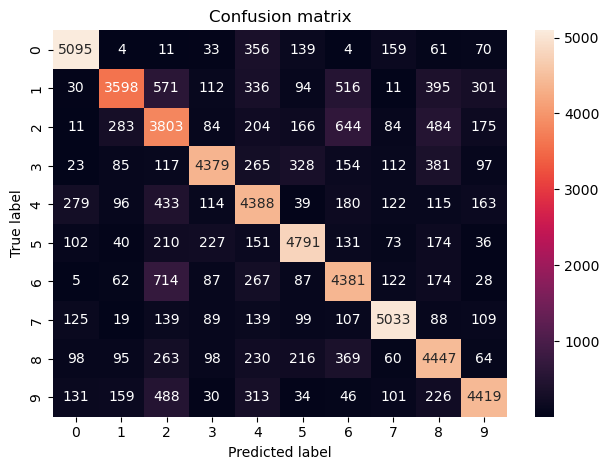

In [84]:
# Compute the confusion matrix
cm=confusion_matrix(Y_test,Y_pred)

# Plot the confusion matrix
plot_conf_matrix(cm)

**COMMENTS:**
From the confusion matrix we can see that pretty much all samples are correcly classified except for some confusion between 2 and 6 (in both directions). 
This makes sense due to the fact that these japanese symbols are handwritten so there might happen that some details are missing (or they're not so clear) that make the network confused. 

**NOTICE:**
Moreover, remember that this is a fully connected neural network trained on not so many samples, so it makes a lot of mistakes. A much better result could've been obtained by means of CNNs (could've reached essentially 99% accuracy, basically CNNs now have got human performance on this kind of task, if they get it wrong is due to very very bad handwriting).